# Baracus Performance

## Setup

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import subprocess
from datetime import date
import re

In [2]:
analysis_version = "2017_07_07"
project_dir_absolute = Path('/gpfs/gsfs6/users/NNDSP')

# Project Directory
project_dir = Path(project_dir_absolute) # needs to be pathlib.Path object

# Bids Directory
bids_bar = project_dir.joinpath('derived/bar_subj') # baracus bids

# Brain Age File
brain_age_file = project_dir.joinpath('anal/analysis_notebooks/NNDSP_famid.csv')

print(brain_age_file.absolute())

/gpfs/gsfs6/users/NNDSP/anal/analysis_notebooks/NNDSP_famid.csv


## Load Baracus Data

In [3]:
bar_subj = [p.as_posix() for p in bids_bar.glob('sub-*')] # search all subj in baracus directory
df_bar_subj = pd.DataFrame(bar_subj) # turn the subjects into df
df_bar_subj.columns = ['subj_path'] # rename column of subj paths to subj_path
df_bar_subj = df_bar_subj.assign(participant = lambda df: df.subj_path.str.extract('sub-(\d{2,4})', expand=True)) # add participant number column

In [4]:
df_single_subject = pd.DataFrame(index=[x+1 for x in range(len(df_bar_subj))], columns = ['participant', 'aseg', 'area', 'thickness', 'stacked-anatomy'])
i = 0
for p in df_bar_subj.subj_path:
    tsv_file = [x for x in Path(p).glob('*.tsv')]
    if tsv_file:
        df_temp = pd.read_csv(tsv_file[0], sep='\t')
        df_single_subject.set_value(i, 'participant', (df_temp.subject_id[0])[4:])
        df_single_subject.set_value(i, 'aseg', df_temp.predicted_age[0])
        df_single_subject.set_value(i, 'area', df_temp.predicted_age[1])
        df_single_subject.set_value(i, 'thickness', df_temp.predicted_age[2])
        df_single_subject.set_value(i, 'stacked-anatomy', df_temp.predicted_age[3])
        i += 1

In [5]:
# Getting Age
df_target = pd.read_csv(brain_age_file, sep=',')
del df_target['nuclear_fam_id']
del df_target['Sex']
del df_target['MRN']

In [6]:
df_bar_subj = df_bar_subj.merge(df_single_subject, on='participant')

In [7]:
df_bar_subj = df_bar_subj.assign(MASKID = lambda df: pd.DataFrame([int(x) for x in df.participant]))
df_bar_subj = df_bar_subj.merge(df_target, on='MASKID')

## Mean Absolute Error

In [8]:
# error of baracus model
from sklearn.metrics import mean_absolute_error

print("Mean Absolute Error (Aseg):", mean_absolute_error(df_bar_subj.iloc[:, 2], df_bar_subj.iloc[:, 7]))
print("Mean Absolute Error (Area):", mean_absolute_error(df_bar_subj.iloc[:, 3], df_bar_subj.iloc[:, 7]))
print("Mean Absolute Error (Thickness):", mean_absolute_error(df_bar_subj.iloc[:, 4], df_bar_subj.iloc[:, 7]))
print("Mean Absolute Error (Stacked Model):", mean_absolute_error(df_bar_subj.iloc[:, 5], df_bar_subj.iloc[:, 7]))

Mean Absolute Error (Aseg): 10.7794454526
Mean Absolute Error (Area): 105.017535768
Mean Absolute Error (Thickness): 15.864500892
Mean Absolute Error (Stacked Model): 13.7877541396


## Plots

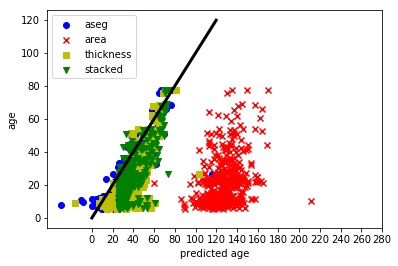

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(0,120,0.1), np.arange(0,120,0.1), c='black', linewidth = 3)
plt.scatter(df_bar_subj.iloc[:, 2], df_bar_subj.iloc[:, 7], c='b')
plt.scatter(df_bar_subj.iloc[:, 3], df_bar_subj.iloc[:, 7], c='r', marker='x')
plt.scatter(df_bar_subj.iloc[:, 4], df_bar_subj.iloc[:, 7], c='y', marker='s')
plt.scatter(df_bar_subj.iloc[:, 5], df_bar_subj.iloc[:, 7], c='g', marker='v')
plot_legend = plt.legend(loc = 'upper left')
plot_legend.get_texts()[0].set_text("aseg")
plot_legend.get_texts()[1].set_text("area")
plot_legend.get_texts()[2].set_text("thickness")
plot_legend.get_texts()[3].set_text("stacked")
plt.xlabel("predicted age")
plt.ylabel("age")
plt.xticks(np.arange(0,300,20))
plt.show()

# Functions for the Greater Good

## Function To Train-Test-Split

In [12]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR

def train_test_pipeline(df_features, df_target, test_size=0.3, random_state=None):
    #split test and train data into equal parts
    X_train, X_test, y_train, y_test = train_test_split(df_features, df_target, test_size = test_size, random_state= random_state)

    # imputer for missing values
    fill_missing = Imputer()
    var_thr = VarianceThreshold()
    normalize = StandardScaler() # standard nomalizer

    # create pipelist for sklearn transformations in order of specification
    pipeline_list = []
    pipeline_list = [('fill_missing', fill_missing),
                     ('var_thr', var_thr),
                     ('normalize', normalize)]
    
    # SVR regression model
    regression_model = SVR(kernel='linear', C=1.0, cache_size=1000)
    pipeline_list.append(('regression_model', regression_model))
    
    # turn pipeline_list into sklearn Pipeline 
    pipe = Pipeline(pipeline_list)
    
    return X_train, X_test, y_train, y_test, pipe

## Function for Plot Pred vs. Age

In [13]:
# plots
import matplotlib.pyplot as plt
import numpy as np

def plot_pred(y_pred_train, y_target_train, y_pred_test, y_target_test):
    plt.plot(numpy.arange(0,80,0.1), numpy.arange(0,80,0.1), c='black', linewidth = 3)
    plt.scatter(y_pred_train, y_target_train, c='b', marker = 'v')
    plt.scatter(y_pred_test, y_target_test, color = 'r', marker = 'x')
    plot_legend = plt.legend(loc = 'upper left')
    plot_legend.get_texts()[0].set_text("train")
    plot_legend.get_texts()[1].set_text("test")
    plt.xlabel("predicted age")
    plt.ylabel("age")
    plt.xticks(np.arange(0,100,20))
    plt.show()

## Function Plot Validation Curve

In [37]:
# Validation Curve
from sklearn.learning_curve import validation_curve
import pylab as plt

def plot_validation_curve(pipe, X_train, y_train):
    param_range = np.logspace(-4, 2, num=18)
    # fixme n_jobs
    train_scores, test_scores = validation_curve(pipe, X_train, y_train, param_name="regression_model__C",
                                                     param_range=param_range)
    
    # plot
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure()
    plt.title("Validation Curve")
    plt.xlabel("C")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
    plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std,
                         alpha=0.2,
                         color="r")
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="g")
    plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2,
                         color="g")
    plt.legend(loc="best")
    plt.show()

## Function Plot Learning Curve

In [16]:
def learning_curve_fct(X, y, out_name, estimator):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.learning_curve import learning_curve
    import os, pickle
    from sklearn.svm import SVR
    from sklearn.linear_model import ElasticNet
    from sklearn.pipeline import Pipeline
    from sklearn.feature_selection import VarianceThreshold
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.preprocessing import Imputer


    def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                            n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
        plt.figure()
        plt.title(title)
        if ylim is not None:
            plt.ylim(*ylim)
            
        plt.xlabel("Training examples")
        plt.ylabel("Score")
        
        train_sizes, train_scores, test_scores = learning_curve(
            estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
        
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        
        plt.grid()
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")

        plt.legend(loc="best")
        return plt
    
    title = 'Learning Curves: ' + out_name
    plot_learning_curve(estimator, title, X, y, cv=5, n_jobs=5, train_sizes=np.linspace(.5, 1.0, 5))
    plt.show()

## Get Age

In [17]:
# Getting Brain Age
df_target = pd.read_csv(brain_age_file, sep=',')
del df_target['nuclear_fam_id']
del df_target['Sex']
del df_target['MRN']

# Train LeiCA_LIFE Models with Shaw Data

## Setup

In [18]:
from pathlib import Path
import pandas as pd
import numpy as np
import subprocess
from datetime import date
import re

In [19]:
analysis_version = "2017_07_07"
project_dir_absolute = Path('/gpfs/gsfs6/users/NNDSP')

# Project Directory
project_dir = Path(project_dir_absolute) # needs to be pathlib.Path object

# Bids Directory
bids_fs = project_dir.joinpath('derived/fs5.3_subj') # freesurfer bids
bids_bar = project_dir.joinpath('derived/bar_subj') # baracus bids

# Brain Age File
brain_age_file = project_dir.joinpath('anal/analysis_notebooks/NNDSP_famid.csv')

print(brain_age_file.absolute())

/gpfs/gsfs6/users/NNDSP/anal/analysis_notebooks/NNDSP_famid.csv


## Load Subjects

In [20]:
import os
from glob import glob

# get the subjects in the freesurfer directory
subj_dirs = [os.path.basename(s) for s in sorted(glob(os.path.join(bids_fs, "sub-*")))]

## Extract Freesurfer Data

In [21]:
import nibabel
import numpy

def vectorize_fs_surf(hemisphere_file):
    image = nibabel.load(hemisphere_file) # load file
    sq_data = image.get_data().squeeze() # squeeze number of features
    vectorized_data = sq_data[numpy.newaxis, ...] # save the squeezed data to vectorized_data
    assert vectorized_data.shape == (1, 2562) # assert that the new squeezed size

    return vectorized_data

In [22]:
def vectorize_fs_tab(aseg):
    df_aseg = pd.read_csv(aseg, index_col=0, delimiter='\t') # read in aseg file
    vectorized_data = df_aseg.values # save volume values in vectorized_data
    assert vectorized_data.shape == (1, 66) # assert that we have 66 volume measurements
    
    return vectorized_data

In [23]:
def combine_surfaces(lh, rh):
    lh_data = vectorize_fs_surf(lh)
    rh_data = vectorize_fs_surf(rh)
    return np.concatenate((lh_data, rh_data), 1)

In [24]:
def get_data(lh_thickness, rh_thickness, lh_area, rh_area, aseg):
    X = {}
    X["thickness"] = combine_surfaces(lh_thickness, rh_thickness) # vectorize cortical thickness
    X["area"] = combine_surfaces(lh_area, rh_area) # vectorize cortical surface area
    X["aseg"] = vectorize_fs_tab(aseg)
    
    return X

In [25]:
def get_features(subject, lh_thickness_file, rh_thickness_file, lh_area_file, rh_area_file, aseg_file):
    X = get_data(lh_thickness_file, rh_thickness_file, lh_area_file, rh_area_file, aseg_file)
    return X

In [26]:
subjects_to_analyze = []

# check baracus directory for extracted information from Freesurfer
# if extracted information exists for that subject, continue
# else, don't use that subject
for s in subj_dirs:
    lh_thickness_file = os.path.join(bids_bar, s, "data", "lh.thickness.mgh")
    rh_thickness_file = os.path.join(bids_bar, s, "data", "rh.thickness.mgh")
    lh_area_file = os.path.join(bids_bar, s, "data", "lh.area.mgh")
    rh_area_file = os.path.join(bids_bar, s, "data", "rh.area.mgh")
    aseg_file = os.path.join(bids_bar, s, "data", "aseg")
    
    if os.path.isfile(lh_area_file) and os.path.isfile(rh_area_file) and os.path.isfile(lh_thickness_file) and os.path.isfile(rh_thickness_file) and aseg_file:
        subjects_to_analyze.append(s)

features = []
for s in subjects_to_analyze:
    # these are guaranteed to exists, since we removed subjects without these files in the previous for loop
    lh_thickness_file = os.path.join(bids_bar, s, "data", "lh.thickness.mgh")
    rh_thickness_file = os.path.join(bids_bar, s, "data", "rh.thickness.mgh")
    lh_area_file = os.path.join(bids_bar, s, "data", "lh.area.mgh")
    rh_area_file = os.path.join(bids_bar, s, "data", "rh.area.mgh")
    aseg_file = os.path.join(bids_bar, s, "data", "aseg")
    
    # get cortical thickness, cortical surface area and subcortical volumes
    temp_X = get_features(s, lh_thickness_file, rh_thickness_file, lh_area_file, rh_area_file, aseg_file)
    temp_X["subj"] = s
    features.append(temp_X)
    
print(features)

[{'thickness': array([[ 3.3053658 ,  3.2269454 ,  2.20984149, ...,  3.91292405,
         3.63811874,  2.89110589]], dtype=float32), 'area': array([[ 35.70466232,  17.68724442,  53.66544724, ...,  43.36124039,
         28.88058472,  38.17415619]], dtype=float32), 'aseg': array([[  4.35950000e+03,   6.25000000e+01,   1.75824000e+04,
          5.68774000e+04,   8.01320000e+03,   4.44800000e+03,
          6.55020000e+03,   1.63310000e+03,   6.69200000e+02,
          1.42950000e+03,   2.31427000e+04,   4.15510000e+03,
          1.48090000e+03,   1.08440000e+03,   6.31500000e+02,
          4.11520000e+03,   4.69000000e+01,   1.51140000e+03,
          6.64310000e+03,   5.62000000e+01,   1.82291000e+04,
          5.87004000e+04,   7.32030000e+03,   4.74420000e+03,
          6.36910000e+03,   1.65470000e+03,   4.36100000e+03,
          1.49300000e+03,   6.12600000e+02,   4.03250000e+03,
          8.62000000e+01,   1.57420000e+03,   0.00000000e+00,
          9.73700000e+02,   0.00000000e+00,   0

## Train Freesurfer Data

In [27]:
# get data
def get_source_data(source, features, target):
    # Get Features
    assert source == 'thickness' or source == 'area' or source == 'aseg'
    arr_ = [x[source] for x in features]
    arr_ = [x[0] for x in arr_]
    narr_ = numpy.array(arr_) # covert into numpy array
        
    df_data_ = pd.DataFrame(narr_)
    df_data_['MASKID'] = pd.Series([int(x['subj'][4:]) for x in features], index=df_data_.index) # add subject number to df
    df_data_ = df_data_.merge(target, on='MASKID') # add subject age to d
    return df_data_

### Single Modal: Cortical Thickness

#### Load Cortical Thickness Data

In [28]:
df_data_ct = get_source_data('thickness', features, df_target)

#### Train Test Split and Pipeline

In [29]:
#split test and train data into equal parts
X_train_ct, X_test_ct, y_train_ct, y_test_ct, pipe_ct = train_test_pipeline(df_data_ct.iloc[:, :5124], df_data_ct.iloc[:,5125], test_size = 0.5, random_state=666)
# fit model
pipe_ct.fit(X=X_train_ct, y=y_train_ct)

Pipeline(steps=[('fill_missing', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('var_thr', VarianceThreshold(threshold=0.0)), ('normalize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression_model', SVR(C=1.0, cache_size=1000, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

#### Prediction and Errors

In [30]:
# prediction and errors
y_predicted_train_ct = pipe_ct.predict(X_train_ct)
y_predicted_test_ct = pipe_ct.predict(X_test_ct)

In [33]:
# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error (Train):", mean_absolute_error(y_train_ct, y_predicted_train_ct))
print("Mean Absolute Error (Test):", mean_absolute_error(y_test_ct, y_predicted_test_ct))
print("R^2 Score (Train):", r2_score(y_train_ct, y_predicted_train_ct))
print("R^2 Score (Test):", r2_score(y_test_ct, y_predicted_test_ct))

Mean Absolute Error (Train): 0.0995490163078
Mean Absolute Error (Test): 5.51270712931
R^2 Score (Train): 0.999953444662
R^2 Score (Test): 0.717736077029


In [34]:
from sklearn.cross_validation import cross_val_predict

y_predicted_ct_cv = cross_val_predict(pipe_ct, X_train_ct, y_train_ct)

#### Plots

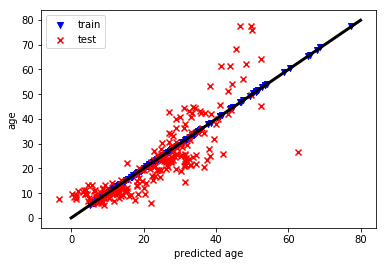

In [35]:
plot_pred(y_predicted_train_ct, y_train_ct, y_predicted_test_ct, y_test_ct)

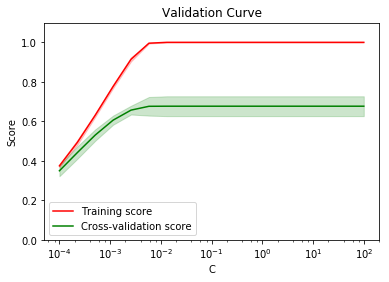

In [39]:
plot_validation_curve(pipe_ct, X_train_ct, y_train_ct)

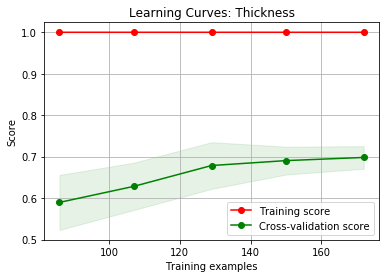

In [40]:
learning_curve_fct(X_train_ct, y_train_ct, 'Thickness', pipe_ct)

### Single Modal: Subcortical Volumes

#### Load Subcortical Volume Data

In [41]:
df_data_sv = get_source_data('aseg', features, df_target)

#### Train Test Split and Pipeline

In [42]:
# Train Test Split
X_train_sv, X_test_sv, y_train_sv, y_test_sv, pipe_sv = train_test_pipeline(df_data_sv.iloc[:, :66], df_data_sv.iloc[:,67], test_size = 0.5, random_state=666)

# fit model
pipe_sv.fit(X=X_train_sv, y=y_train_sv)

Pipeline(steps=[('fill_missing', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('var_thr', VarianceThreshold(threshold=0.0)), ('normalize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression_model', SVR(C=1.0, cache_size=1000, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

#### Prediction and Errors 

In [43]:
# prediction and errors
y_predicted_train_sv = pipe_sv.predict(X_train_sv)
y_predicted_test_sv = pipe_sv.predict(X_test_sv)

In [44]:
# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error (Train):", mean_absolute_error(y_train_sv, y_predicted_train_sv))
print("Mean Absolute Error (Test):", mean_absolute_error(y_test_sv, y_predicted_test_sv))
print("R^2 Score (Train):", r2_score(y_train_sv, y_predicted_train_sv))
print("R^2 Score (Test):", r2_score(y_test_sv, y_predicted_test_sv))

Mean Absolute Error (Train): 3.97665220645
Mean Absolute Error (Test): 5.21305831296
R^2 Score (Train): 0.820114639539
R^2 Score (Test): 0.733394515213


In [45]:
from sklearn.cross_validation import cross_val_predict

y_predicted_sv_cv = cross_val_predict(pipe_sv, X_train_sv, y_train_sv)

#### Plots

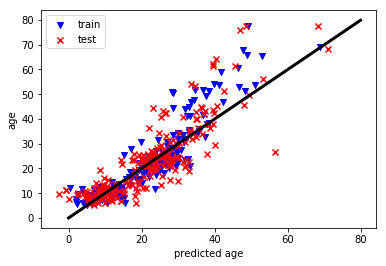

In [46]:
plot_pred(y_predicted_train_sv, y_train_sv, y_predicted_test_sv, y_test_sv)

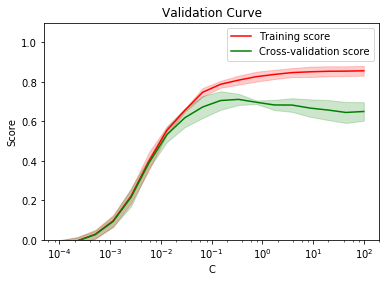

In [47]:
plot_validation_curve(pipe_sv, X_train_sv, y_train_sv)

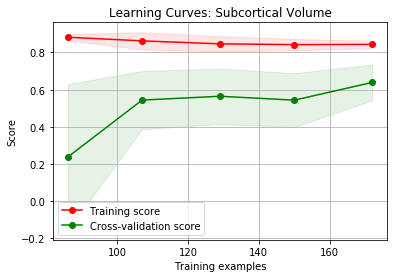

In [48]:
learning_curve_fct(X_train_sv, y_train_sv, 'Subcortical Volume', pipe_sv)

### Single Modal: Cortical Surface Area

#### Load Cortical Area Data

In [49]:
df_data_ca = get_source_data('area', features, df_target)

#### Train Test Split and Pipeline

In [50]:
# Train Test Split

#split test and train data into equal parts
X_train_ca, X_test_ca, y_train_ca, y_test_ca, pipe_ca = train_test_pipeline(df_data_ca.iloc[:, :5124], df_data_ca.iloc[:,5125], test_size = 0.5, random_state=666)

# fit model
pipe_ca.fit(X=X_train_ca, y=y_train_ca)

Pipeline(steps=[('fill_missing', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('var_thr', VarianceThreshold(threshold=0.0)), ('normalize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression_model', SVR(C=1.0, cache_size=1000, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

#### Prediction and Errors 

In [51]:
# prediction and errors
y_predicted_train_ca = pipe_ca.predict(X_train_ca)
y_predicted_test_ca = pipe_ca.predict(X_test_ca)

In [52]:
# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error (Train):", mean_absolute_error(y_train_ca, y_predicted_train_ca))
print("Mean Absolute Error (Test):", mean_absolute_error(y_test_ca, y_predicted_test_ca))
print("R^2 Score (Train):", r2_score(y_train_ca, y_predicted_train_ca))
print("R^2 Score (Test):", r2_score(y_test_ca, y_predicted_test_ca))

Mean Absolute Error (Train): 0.100046625236
Mean Absolute Error (Test): 6.63016112126
R^2 Score (Train): 0.999953089162
R^2 Score (Test): 0.619951062739


In [53]:
from sklearn.cross_validation import cross_val_predict

y_predicted_ca_cv = cross_val_predict(pipe_ca, X_train_ca, y_train_ca)

#### Plots

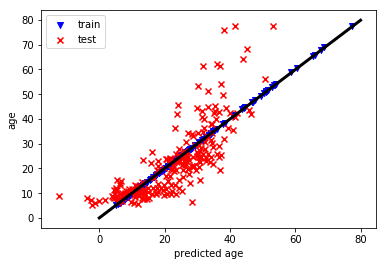

In [54]:
plot_pred(y_predicted_train_ca, y_train_ca, y_predicted_test_ca, y_test_ca)

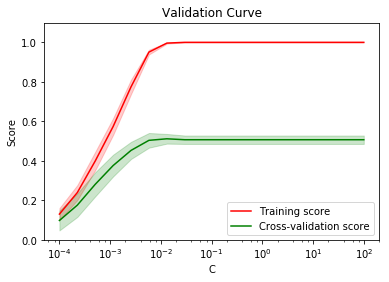

In [55]:
plot_validation_curve(pipe_ca, X_train_ca, y_train_ca)

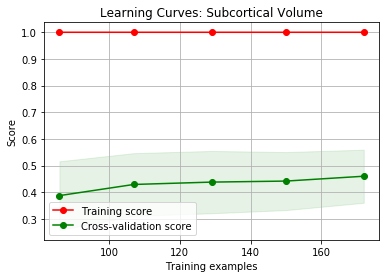

In [56]:
learning_curve_fct(X_train_ca, y_train_ca, 'Subcortical Volume', pipe_ca)

### Stacked Anatomy

#### Stack Predicted Values

In [57]:
def get_stacked_ages(y_train, y_predicted_train, y_predicted_cv, y_test, y_predicted_test ):
    # stack predicted for cortical thickness
    
    # merge predicted ct for train 
    df_y_train = pd.DataFrame(y_train)
    df_y_train = df_y_train.assign(indx = lambda df: df.index)
    df_y_train = df_y_train.assign(pred_age_test = y_predicted_train)
    df_y_train = df_y_train.assign(y_predicted_cv = y_predicted_cv)
    df_y_train = df_y_train.assign(split_group = "train")
    
    # merge predicted ct for test
    df_y_test = pd.DataFrame(y_test)
    df_y_test = df_y_test.assign(indx = lambda df: df.index)
    df_y_test = df_y_test.assign(pred_age_test = y_predicted_test)
    df_y_test = df_y_test.assign(split_group = "test")
    
    # concat ct test and ct train together
    df_y = pd.concat([df_y_train, df_y_test])
    
    # sort by index
    df_y = df_y.sort_index()
    
    return df_y

In [58]:
df_y_ct = get_stacked_ages(y_train_ct, y_predicted_train_ct, y_predicted_ct_cv, y_test_ct, y_predicted_test_ct)
df_y_ca = get_stacked_ages(y_train_ca, y_predicted_train_ca, y_predicted_ca_cv, y_test_ca, y_predicted_test_ca)
df_y_sv = get_stacked_ages(y_train_sv, y_predicted_train_sv, y_predicted_sv_cv, y_test_sv, y_predicted_test_sv)

#### Stacking Function Inputs

In [59]:
target = 'age'

source_dict = {'aseg': df_y_sv,
                'ct': df_y_ct,
                'ca': df_y_ca,
              }

source_selection_dict = {'fs': ['aseg', 'ct', 'ca'],}

#### Training Random Forest Function

In [60]:
import os
import pickle
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cross_validation import cross_val_predict, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error

def tune_and_train_rf(X_train, y_train, target, strat_k_fold=None):
    '''
    Uses oob estimates to find optimal max_depth between None + 0...20
    Refits with best max_depth
    '''
    oob_r2 = []
    cv_list = [x for x in range(1, 20)]
    for md in cv_list:
        rf = RandomForestRegressor(n_estimators=100, max_depth=md, oob_score=True, random_state=0, n_jobs=-1)
        rf.fit(X_train, y_train)
        oob_r2.append(rf.oob_score_)

    best_max_depth = cv_list[np.argmax(oob_r2)]
    print("best max_depth: %s" % best_max_depth)

    # CV
    rf = RandomForestRegressor(n_estimators=100, max_depth=best_max_depth, oob_score=True, random_state=0, n_jobs=-1)

    cv_results = None
    if strat_k_fold:
        y_predicted_cv = cross_val_predict(rf, X_train, y_train, cv=strat_k_fold, n_jobs=-1)
        cv_r2 = []
        cv_mae = []
        for k_train, k_test in strat_k_fold:
            cv_r2.append(r2_score(y_train[k_test], y_predicted_cv[k_test]))
            cv_mae.append(mean_absolute_error(y_train[k_test], y_predicted_cv[k_test]))
        cv_results = {'y_predicted_cv': y_predicted_cv,
                      'cv_r2': cv_r2,
                      'cv_mae': cv_mae,
                      'oob_r2': oob_r2}

    # refit
    rf.fit(X_train, y_train)
    return rf, cv_results

#### Stacking Function

In [96]:
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.cross_validation import cross_val_predict, StratifiedKFold

def stacking(source_dict, source_selection_dict, target, run_fitting=True):
    df_in = {}

    # create df_in for ct, ca and sv and add a source column to identify ct, ca or sv
    for s, f in source_dict.items():
        df_in[s] = f
        df_in[s]['source'] = s
        
    # go though fs key
    for stacking_crit in source_selection_dict.keys():
        file_pref = target + '__' + stacking_crit + '__'
        scores_test = pd.DataFrame([])
        df_all = pd.DataFrame([]) # empty df
    
        # concatenate ct, ca, sv vertically
        for s in source_selection_dict[stacking_crit]:
            df_all = pd.concat((df_all, df_in[s]))
    
        # get one single source example to get age...
        # gets ct because it's the last item in the key
        df_single_source = df_in[s]
    
        # add columns in the case of test-only data
        if 'split_group' not in df_all:
            df_all['split_group'] = 'test'
    
        # add 'select', 'y_pred_cv', 'sample_weights', 'train_group_2samp' and 'study if those fields not already provided
        for a in ['select', 'y_predicted_cv','sample_weights', 'train_group_2samp', 'study']:
            if a not in df_all:
                df_all[a] = np.nan
    
        # create a df that only takes certain columns of df_all
        df = df_all[['source', 'age_at_scan', 'split_group', 'select', 'y_predicted_cv', 'pred_age_test', 'sample_weights', 'train_group_2samp', 'study']]
    
        # separate df into test subjects
        test_ind = df['split_group'] == 'test'
        df_test = df[test_ind].copy()
    
        # run_fitting on train data 
        if run_fitting:  # fit rf
            print ('Fitting stacking model')
        
            # split df into train subjects
            train_ind = ((df['split_group'] == 'train') | (df['train_group_2samp'] == True))
            df_train = df[train_ind].copy() 
        
            # pivot table so that df_train displays index as rows, aseg, ca and ct as columns and y_pred_cv for corresponding values
            dd_train = df_train.pivot_table(values='y_predicted_cv', columns='source', index=df_train.index)
        
            # get ['aseg', 'ca', 'ct']
            single_sources = dd_train.columns.values
            # get mean y_pred across the three sources
            dd_train['mean_pred'] = dd_train.mean(1)
            # add actual age in
            dd_train = dd_train.join(df_single_source[['age_at_scan']], how='left')
        
            # split into training features and target
            X_train, y_train = dd_train[single_sources], dd_train['age_at_scan']
        
            # Call Tuning and Training Random Forest Function
            rf, cv_results = tune_and_train_rf(X_train, y_train, target)
        
            # Plot Feature Importance
            fi = pd.DataFrame(rf.feature_importances_, columns=['feature_importances'], index=single_sources)
            plt.figure()
            sns.barplot(fi.feature_importances, fi.index.values)
            plt.xlim([0, 1])
            plt.show()
        
            # Get Training Error
            y_predicted_train_stack = rf.predict(X_train)
            r2_train = r2_score(y_train, y_predicted_train_stack)
            mae_train = mean_absolute_error(y_train, y_predicted_train_stack)
            
            dd_train['pred_age_train'] = y_predicted_train_stack

            plt.figure()
            f = sns.jointplot('age_at_scan', 'pred_age_train', data=dd_train, xlim=(10, 90), ylim=(10, 90))
            ax = sns.plt.gca()
            plt.show()
        else:
            rf_file = rf_file_template.format(stacking_crit=stacking_crit)
            rf = pickle.load(open(rf_file))
            dd_train = pd.DataFrame([])
        
        # Prediction on Test Set
        
        # Pivot Test Subject so that columns = aseg, ca, ct and rows are the index of test subjects and values are predicted ages
        dd_test = df_test.pivot_table(values='pred_age_test', columns='source', index=df_test.index)
    
        # get ['aseg', 'ca', 'ct']
        single_sources = dd_test.columns.values
    
        dd_test['mean_pred'] = dd_test.mean(1) # calculate mean predicted age
        dd_test = dd_test.join(df_single_source[['age_at_scan']], how='left') # add real age at the end of the df
    
        # separate into test features and test target
        X_test, y_test = dd_test[single_sources], dd_test['age_at_scan']
        dd_test['pred_age_test'] = rf.predict(X_test)
    
        for m in source_selection_dict[stacking_crit] + ['mean_pred', 'pred_age_test']:
            scores_test.ix[m, 'r2'] = r2_score(dd_test['age_at_scan'], dd_test[m])
            scores_test.ix[m, 'rpear'] = np.corrcoef(dd_test['age_at_scan'], dd_test[m])[0, 1]
            scores_test.ix[m, 'rpear2'] = np.corrcoef(dd_test['age_at_scan'], dd_test[m])[0, 1] ** 2
            scores_test.ix[m, 'mae'] = mean_absolute_error(dd_test['age_at_scan'], dd_test[m])
            scores_test.ix[m, 'medae'] = median_absolute_error(dd_test['age_at_scan'], dd_test[m])
        
            plt.figure()
            plt.scatter(dd_test['age_at_scan'], dd_test[m])
            plt.plot([10, 90], [10, 90])
            plt.xlim([10, 90]);
            plt.ylim([10, 90])
            plt.title('predictions TEST: %s (%s)\n%.3f' % (m, stacking_crit, scores_test.ix[m, 'r2']))
            plt.gca().set_aspect('equal', adjustable='box')
            plt.show()
        
        return scores_test, dd_train, dd_test, rf

Fitting stacking model
best max_depth: 6


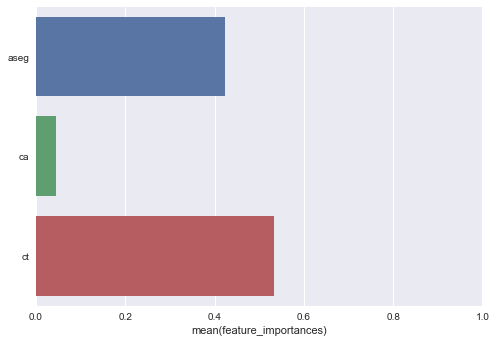

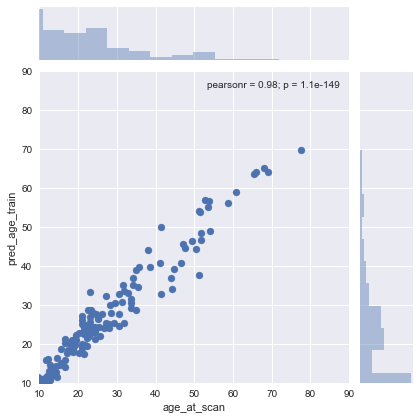

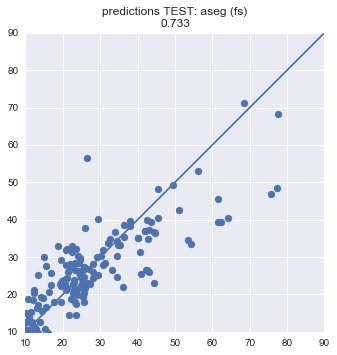

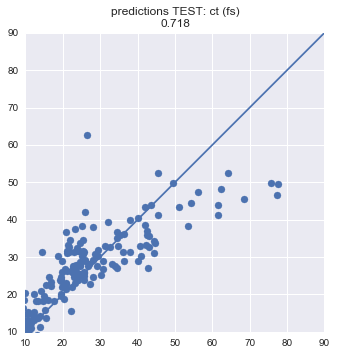

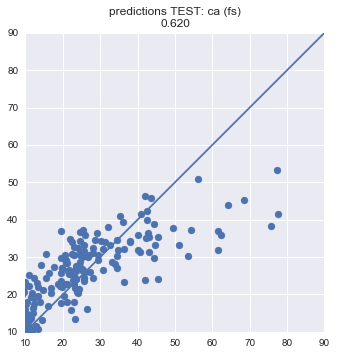

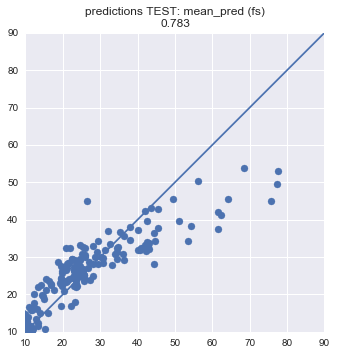

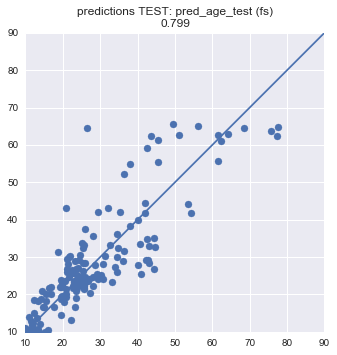

In [97]:
scores_test, dd_train, dd_test, pipe_stack = stacking(source_dict, source_selection_dict, target)

In [99]:
dd_test

,aseg,ca,ct,mean_pred,age_at_scan,pred_age_test
0,24.980828,34.634160,30.741020,30.118670,28.542094,27.755792
1,21.677855,26.129521,42.036309,29.947895,25.957563,37.576065
3,8.530255,4.986572,13.131599,8.882809,7.926078,9.710205
6,29.342025,31.198475,27.488072,29.342857,24.498289,24.703067
7,26.599490,26.626289,27.359117,26.861632,23.145791,22.461423
8,10.497409,13.599828,7.314362,10.470533,7.767283,8.879613
11,22.805715,23.860415,27.476844,24.714325,22.592745,22.202314
12,17.851223,13.339504,23.004690,18.065139,23.359343,16.652235
14,19.731247,20.684057,32.421989,24.279098,23.707050,25.315810
15,20.380290,24.383183,25.736786,23.500086,25.560575,21.322293


# Train Basic Anatomical Features

## Setup

In [68]:
from pathlib import Path
import pandas as pd
import numpy as np
import subprocess
from datetime import date
import re

In [69]:
analysis_version = "2017_07_07"
project_dir_absolute = Path('/gpfs/gsfs6/users/NNDSP')

# Project Directory
project_dir = Path(project_dir_absolute) # needs to be pathlib.Path object

# Bids Directory
bids_bar = project_dir.joinpath('derived/bar_subj') # baracus bids

# Brain Age File
brain_age_file = project_dir.joinpath('anal/analysis_notebooks/NNDSP_famid.csv')

print(brain_age_file.absolute())

/gpfs/gsfs6/users/NNDSP/anal/analysis_notebooks/NNDSP_famid.csv


## Load Subjects

In [70]:
import os
from glob import glob

# get the subjects in the freesurfer directory
subj_dirs = [os.path.basename(s) for s in sorted(glob(os.path.join(bids_fs, "sub-*")))]

In [71]:
subjects_to_analyze = []

# check baracus directory for extracted information from Freesurfer
# if extracted information exists for that subject, continue
# else, don't use that subject
for s in subj_dirs:
    lh_thickness_file = os.path.join(bids_bar, s, "data", "lh.thickness.mgh")
    rh_thickness_file = os.path.join(bids_bar, s, "data", "rh.thickness.mgh")
    lh_area_file = os.path.join(bids_bar, s, "data", "lh.area.mgh")
    rh_area_file = os.path.join(bids_bar, s, "data", "rh.area.mgh")
    aseg_file = os.path.join(bids_bar, s, "data", "aseg")
    
    if os.path.isfile(lh_area_file) and os.path.isfile(rh_area_file) and os.path.isfile(lh_thickness_file) and os.path.isfile(rh_thickness_file) and aseg_file:
        subjects_to_analyze.append(s)

## Extract Anatomical Feature Data

In [102]:
df_atf = pd.DataFrame([])
df_atf = df_atf.assign(MASKID = [int(x[4:]) for x in subjects_to_analyze])
df_atf = df_atf.merge(df_target, on = 'MASKID')

In [103]:
white_matter = []
grey_matter = []
csf = []
intra_cran_vol = []

for s in subjects_to_analyze:
    # calculate white matter
    df_tempsub = pd.DataFrame.from_csv(bids_bar.joinpath(s + "/data/aseg").as_posix(), sep='\t')
    white_matter_ms = df_tempsub.iloc[0]['Left-Cerebellum-White-Matter'] + df_tempsub.iloc[0]['Right-Cerebellum-White-Matter'] + df_tempsub.iloc[0]['CorticalWhiteMatterVol']
    white_matter.append(white_matter_ms)
    
    # calculate grey matter
    grey_matter_ms = df_tempsub.iloc[0]['SubCortGrayVol']
    grey_matter.append(grey_matter_ms)
    
    # calculate csf
    csf_ms = df_tempsub.iloc[0]['CSF']
    csf.append(csf_ms)
    
    # calculate intracranial volume
    intra_cran_vol_ms = df_tempsub.iloc[0]['EstimatedTotalIntraCranialVol']
    intra_cran_vol.append(intra_cran_vol_ms)

In [104]:
def calc_fraction(matter, total):
    for indx in range(len(matter)):
        matter[indx] = matter[indx]/total[indx]
        
    return matter

In [105]:
# calculate white matter fraction
white_matter = calc_fraction(white_matter, intra_cran_vol)

# calculate grey matter fraction
grey_matter = calc_fraction(grey_matter, intra_cran_vol)

# calculate csf fraction
csf = calc_fraction(csf, intra_cran_vol)

In [217]:
df_atf = df_atf.assign(Intra_Cran_Vol = intra_cran_vol)
df_atf = df_atf.assign(WM_Frac = white_matter)
df_atf = df_atf.assign(GM_Frac = grey_matter)
df_atf = df_atf.assign(CSF_Frac = csf)

## Train Basic Anatomical Feature Data

### Train Test Splot and Pipeline

In [132]:
# split test into training and test set. This must be the same split as for the stacked model for right Wilcoxon Comparison
import pandas as pd

# get X_train_atf
X_train_atf = []
[X_train_atf.append(df_atf.iloc[x,:]) for x in dd_train.index]
X_train_atf = pd.DataFrame(X_train_atf)

# get corresponding y_train_atf
y_train_atf = X_train_atf.age_at_scan

del X_train_atf['age_at_scan']
X_train_atf = X_train_atf.iloc[:,1:]

In [134]:
# split test into training and test set. This must be the same split as for the stacked model for right Wilcoxon Comparison
import pandas as pd

# get X_test_atf
X_test_atf = []
[X_test_atf.append(df_atf.iloc[x,:]) for x in dd_test.index]
X_test_atf = pd.DataFrame(X_test_atf)

# get corresponding y_train_atf
y_test_atf = X_test_atf.age_at_scan

del X_test_atf['age_at_scan']
X_test_atf = X_test_atf.iloc[:,1:]

In [133]:
# pipeline

# imputer for missing values
fill_missing = Imputer()
var_thr = VarianceThreshold()
normalize = StandardScaler() # standard nomalizer

# create pipelist for sklearn transformations in order of specification
pipeline_list = []
pipeline_list = [('fill_missing', fill_missing),
                 ('var_thr', var_thr),
                 ('normalize', normalize)]

# SVR regression model
regression_model = SVR(kernel='linear', C=1.0, cache_size=1000)
pipeline_list.append(('regression_model', regression_model))
    
# turn pipeline_list into sklearn Pipeline 
pipe_atf = Pipeline(pipeline_list)
pipe_atf.fit(X=X_train_atf, y=y_train_atf)

Pipeline(steps=[('fill_missing', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('var_thr', VarianceThreshold(threshold=0.0)), ('normalize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression_model', SVR(C=1.0, cache_size=1000, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

### Prediction and Errors

In [135]:
# prediction and errors
y_predicted_train_atf = pipe_atf.predict(X_train_atf)
y_predicted_test_atf = pipe_atf.predict(X_test_atf)

In [136]:
# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error (Train):", mean_absolute_error(y_train_atf, y_predicted_train_atf))
print("Mean Absolute Error (Test):", mean_absolute_error(y_test_atf, y_predicted_test_atf))
print("R^2 Score (Train):", r2_score(y_train_atf, y_predicted_train_atf))
print("R^2 Score (Test):", r2_score(y_test_atf, y_predicted_test_atf))

Mean Absolute Error (Train): 6.94790867863
Mean Absolute Error (Test): 7.00265588507
R^2 Score (Train): 0.572966168923
R^2 Score (Test): 0.502147430175


In [137]:
from sklearn.cross_validation import cross_val_predict

y_predicted_atf_cv = cross_val_predict(pipe_atf, X_train_atf, y_train_atf)

### Plots

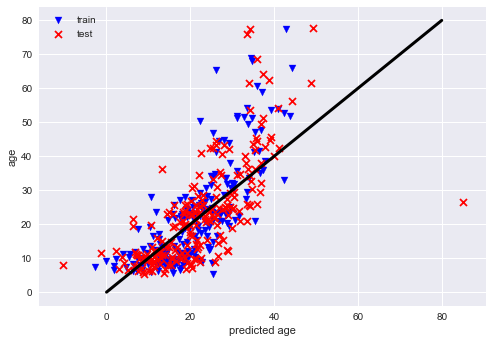

In [138]:
plot_pred(y_predicted_train_atf, y_train_atf, y_predicted_test_atf, y_test_atf)

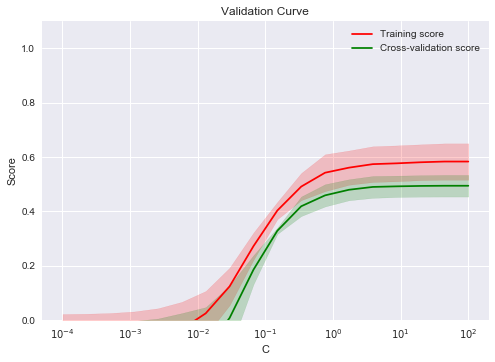

In [139]:
plot_validation_curve(pipe_atf, X_train_atf, y_train_atf)

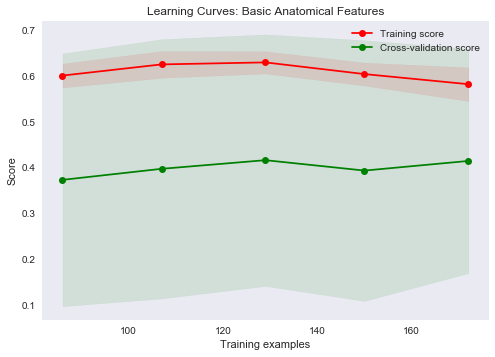

In [140]:
learning_curve_fct(X_train_atf, y_train_atf, 'Basic Anatomical Features', pipe_atf)

# Test HCP Data

# Statistical Tests

## Hypothesis #1

If we train a previously presented machine learning model predicting age from a large number of derived anatomical features on a new data set, it will perform better than chance at predicting age outside of the training data.

In [84]:
# get all the subject ages
subject_ages = [x for x in df_data_ca.age_at_scan]
df_subject_ages = pd.DataFrame(subject_ages)
# df of random age predictions
df_random_ages = pd.DataFrame([])
df_random_ages = df_random_ages.assign(MASKID = df_data_ca.MASKID)

In [85]:
import random
import pandas as pd

# generate 1000 iterations of random ages
for i in range(1000):
    rand_age = []
    for sub in range(len(df_random_ages)):
        rand_indx = random.randrange(0, len(subject_ages))
        rand_age.append(subject_ages[rand_indx])
    df_temp = pd.DataFrame(rand_age)
    df_temp.columns = [str(i+1)]
    df_random_ages = pd.concat([df_random_ages, df_temp], axis=1)

In [86]:
# calculate MAE for each random prediction
# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

arr_mae = []
for i in range(df_random_ages.shape[1]-1):
    arr_mae.append(mean_absolute_error(df_subject_ages, df_random_ages.iloc[:, i+1]))

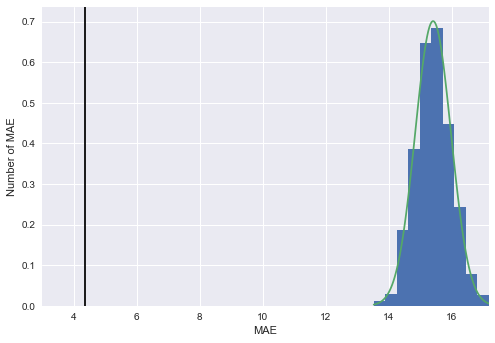

In [87]:
# plot MAE Distribution
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab

# plotting the Histogram
plt.figure(1)
plt.hist(arr_mae, normed = True)
plt.xlim(3, max(arr_mae))
plt.xlabel("MAE")
plt.ylabel("Number of MAE")

# fitting a Gaussian
mean = np.mean(arr_mae)
variance = np.var(arr_mae)
sigma = np.sqrt(variance)
x = np.linspace(min(arr_mae), max(arr_mae), 100)
plt.plot(x, mlab.normpdf(x, mean, sigma))

# plot MAE complex
plt.axvline(x=scores_test.get_value(index='pred_age_test', col='mae'), ymax=250, color='k')

plt.show()

In [88]:
# Calculating Percentile of Score
from scipy.stats import percentileofscore

percentile_mae = percentileofscore(arr_mae, scores_test.get_value(index='pred_age_test', col='mae'))
print(percentile_mae)

0.0


## Hypothesis #2 

The model trained with many derived features will have better out of sample performance than a model trained with fewer, simpler features.

In [211]:
def plot_simple_v_complex(y_one, y_two, title=None):
    if title == None:
        add = ""
    else:
        add = title
    
    plt.figure(1)
    plt.figure(figsize=(5,5))
    plt.plot(numpy.arange(0,80,0.1), numpy.arange(0,80,0.1), c='black', linewidth = 3)
    plt.scatter(y_one, y_two)
    plt.ylim(0, max(y_two))
    plt.xlim(0, max(y_one))
    plt.xlabel("Simple Model Prediction " + add)
    plt.ylabel("Complex Model Prediction " + add)
    
    plt.show()

In [212]:
# Wilcoxon on the Training Set
from scipy.stats import wilcoxon
statistic, pvalue = wilcoxon(y_predicted_train_atf, dd_train.pred_age_train)

sum = len(dd_train.pred_age_train)*(len(dd_train.pred_age_train)+1)/2

print("Statistic: ", statistic)
print("Pvalue: ", pvalue)
print("Correlation: ", statistic/sum)

Statistic:  10991.0
Pvalue:  0.497888649029
Correlation:  0.473341946598


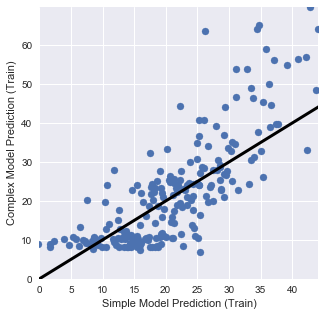

In [213]:
plot_simple_v_complex(y_predicted_train_atf, dd_train.pred_age_train, "(Train)")

In [214]:
# Wilcoxon on the Test Set
from scipy.stats import wilcoxon
statistic, pvalue = wilcoxon(y_predicted_test_atf, dd_test.pred_age_test)

sum = len(dd_test.pred_age_test)*(len(dd_test.pred_age_test)+1)/2

print("Statistic: ", statistic)
print("Pvalue: ", pvalue)
print("Correlation: ", statistic/sum)

Statistic:  11014.0
Pvalue:  0.443939878111
Correlation:  0.469960744154


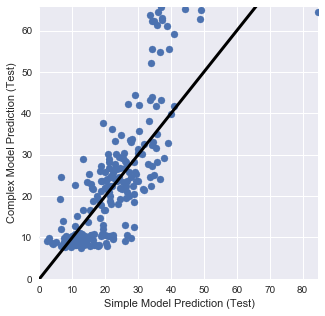

In [215]:
plot_simple_v_complex(y_predicted_test_atf, dd_test.pred_age_test, "(Test)")

In [177]:
# Wilcoxon on the Training + Test Set
# get total for simple model
y_predicted_total_atf = []
[y_predicted_total_atf.append(x) for x in y_predicted_train_atf]
[y_predicted_total_atf.append(x) for x in y_predicted_test_atf]
# get total for complex model
y_predicted_total_stack = []
[y_predicted_total_stack.append(x) for x in dd_train.pred_age_train]
[y_predicted_total_stack.append(x) for x in dd_test.pred_age_test]

from scipy.stats import wilcoxon

statistic, pvalue = wilcoxon(y_predicted_total_atf, y_predicted_total_stack)

sum = len(y_predicted_total_atf)*(len(y_predicted_total_atf)+1)/2

print("Statistic: ", statistic)
print("Pvalue: ", pvalue)
print("Correlation: ", statistic/sum)

Statistic:  43910.0
Pvalue:  0.307957548904
Correlation:  0.471663659019


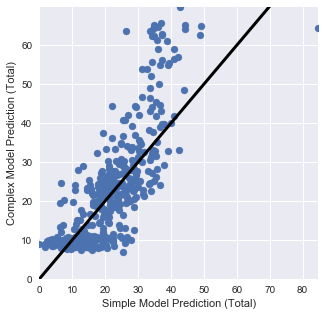

In [216]:
plot_simple_v_complex(y_predicted_total_atf, y_predicted_total_stack, "(Total)")

## Hypothesis #3

The model trained with many derived features will perform better than the model with fewer, simpler features when tested on data collected at different sites. 